In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base.datetools import dates_from_str
import seaborn as sns

%pip install xlrd
%pip install --upgrade statsmodels


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


In [18]:
# The path to the Excel file with the Mona dataset
file_path = 'monadata2023.xlsx'

# Load the dataset from the Excel file
mona_data = pd.read_excel(file_path)

# Transpose the dataset to convert rows to columns
mona_data_transposed = mona_data.T
mona_data_transposed.columns = mona_data_transposed.iloc[0]  # Set the first row as column names
mona_data_transposed = mona_data_transposed[1:]  # Remove the first row which is now column headers

# Convert the index to PeriodIndex with a quarterly frequency
mona_data_transposed.index = pd.PeriodIndex(mona_data_transposed.index, freq='Q')

# Replace variable_names with the actual variable names from your data
variable_names = ['imm', 'efkrks', 'fy', 'pcpdk']

# Function to check for stationarity and take first difference if necessary
def check_stationarity_and_difference(df, variable):
    series = df[variable].astype(float)  # Ensure the data type is float for the adfuller test
    result = adfuller(series.dropna())
    if result[1] > 0.05:  # Non-stationary, take first difference
        return series.diff().dropna()
    else:
        return series

# Apply the stationarity check and differencing to the relevant variables
for variable in variable_names:
    mona_data_transposed[variable] = check_stationarity_and_difference(mona_data_transposed, variable)

# Drop any rows that have NaN values resulting from differencing
mona_data_transposed.dropna(inplace=True)

# Make sure there are no infinite values in the dataset
mona_data_transposed.replace([np.inf, -np.inf], np.nan, inplace=True)
mona_data_transposed.dropna(inplace=True)

# Check if there are still any NaNs or infs in the data
assert not mona_data_transposed.isnull().values.any(), "NaN values detected"
assert not np.isinf(mona_data_transposed.values).any(), "Inf values detected"

# Print first ten observations
first_ten_observations_specific = mona_data_transposed[variable_names].head(10)
first_ten_observations_specific

Unnamed: 0,imm,efkrks,fy,pcpdk
1999Q1,-0.009606,-1.619633,14.3648,0.004825
1999Q2,-0.006411,-1.370333,8.2612,0.004900
1999Q3,-0.000876,-0.810967,9.9388,0.007011
1999Q4,0.002086,-0.908467,22.6328,0.006762
2000Q1,0.003593,-1.391600,15.9980,0.005763
2000Q2,0.006977,-1.289467,18.8596,0.005437
2000Q3,0.006059,-0.373733,4.6284,0.004047
2000Q4,0.004965,-0.336133,16.4284,0.006182
2001Q1,-0.000218,2.190333,-18.4200,0.003718
2001Q2,-0.000705,-0.834633,8.1924,0.006789


In [17]:
# Define a mapping for renaming variables to more descriptive names
variable_rename_map = {
    'fy': 'output',
    'imm': 'interest rate',
    'efkrks': 'exchange rate',
    'pcpdk': 'inflation'
}

# Rename the variables in the dataframe
mona_data_for_var = mona_data_transposed[variable_names]
mona_data_for_var_renamed = mona_data_for_var.rename(columns=variable_rename_map)

# Fit the VAR model with the renamed variables
var_model_renamed = VAR(mona_data_for_var_renamed)
var_results_renamed = var_model_renamed.fit(maxlags=2, ic='aic')

# Print first ten observations
first_ten_observations_renamed = mona_data_for_var_renamed.head(10)
first_ten_observations_renamed

Unnamed: 0,interest rate,exchange rate,output,inflation
1999Q1,-0.009606,-1.619633,14.3648,0.004825
1999Q2,-0.006411,-1.370333,8.2612,0.004900
1999Q3,-0.000876,-0.810967,9.9388,0.007011
1999Q4,0.002086,-0.908467,22.6328,0.006762
2000Q1,0.003593,-1.391600,15.9980,0.005763
2000Q2,0.006977,-1.289467,18.8596,0.005437
2000Q3,0.006059,-0.373733,4.6284,0.004047
2000Q4,0.004965,-0.336133,16.4284,0.006182
2001Q1,-0.000218,2.190333,-18.4200,0.003718
2001Q2,-0.000705,-0.834633,8.1924,0.006789


<Figure size 1400x1000 with 0 Axes>

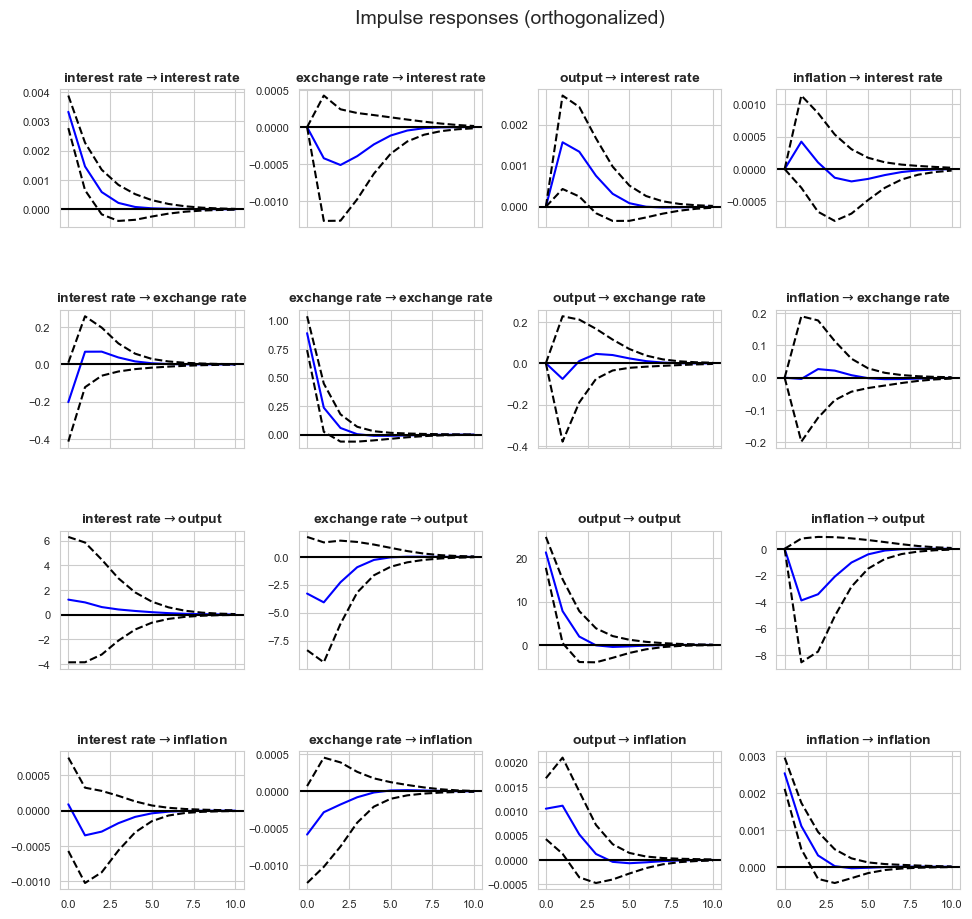

In [15]:
# Analyze impulse response functions with renamed variables
irf_renamed = var_results_renamed.irf(10)  # Analyze the effect over 10 periods

# Set figure size
plt.figure(figsize=(14, 10))

# Plot the impulse response functions
irf_plot = irf_renamed.plot(orth=True)  # Use orthogonalized impulses

# Improve the overall aesthetics
sns.set_style('whitegrid')

# Adjust individual plot parameters to prevent overlapping titles and labels
for i, ax in enumerate(irf_plot.axes):
    # Improve spacing and font sizes for clarity
    ax.set_title(ax.get_title(), fontsize=10, fontweight='bold')
    ax.xaxis.label.set_visible(False)  # Hide x-axis labels to prevent overlap
    ax.yaxis.label.set_visible(False)  # Hide y-axis labels to prevent overlap
    ax.tick_params(labelsize=8)       # Reduce tick label size for space

# Tweak overall spacing between plots in the grid
plt.subplots_adjust(top=0.9, bottom=0.1, hspace=0.6, wspace=0.3)

# Show the updated plot
plt.show()


In [12]:
# Fit the VAR model
var_model = VAR(mona_data_for_var_renamed)  # Make sure to use the dataset with the renamed variables
var_results = var_model.fit(maxlags=2, ic='aic')

# Check if the model is stable
is_model_stable = var_results.is_stable()
print(f"Model is stable: {is_model_stable}")

# If the model is unstable, increase the number of lags
if not is_model_stable:
    # Try with more lags and check the stability of each model
    for i in range(1, 6):  # Assumption: Check up to 5 lags
        var_results = var_model.fit(i)
        if var_results.is_stable():
            print(f"Model with {i} lags is stable.")
            break
    else:
        print("No stable model found for up to 5 lags.")

# Print the results with renamed variables
summary = str(var_results.summary())
for original, rename in variable_rename_map.items():
    summary = summary.replace(original, rename)

print(summary)

Model is stable: True
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 12, Apr, 2024
Time:                     16:46:56
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -16.5629
Nobs:                     69.0000    HQIC:                  -16.9536
Log likelihood:           222.134    FPE:                3.35763e-08
AIC:                     -17.2105    Det(Omega_mle):     2.53806e-08
--------------------------------------------------------------------
Results for equation interest rate
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   -0.001312         0.000748           -1.753           0.080
L1.interest rate         0.404312         0.101673            3.977           0.000
L1.exchange rate  

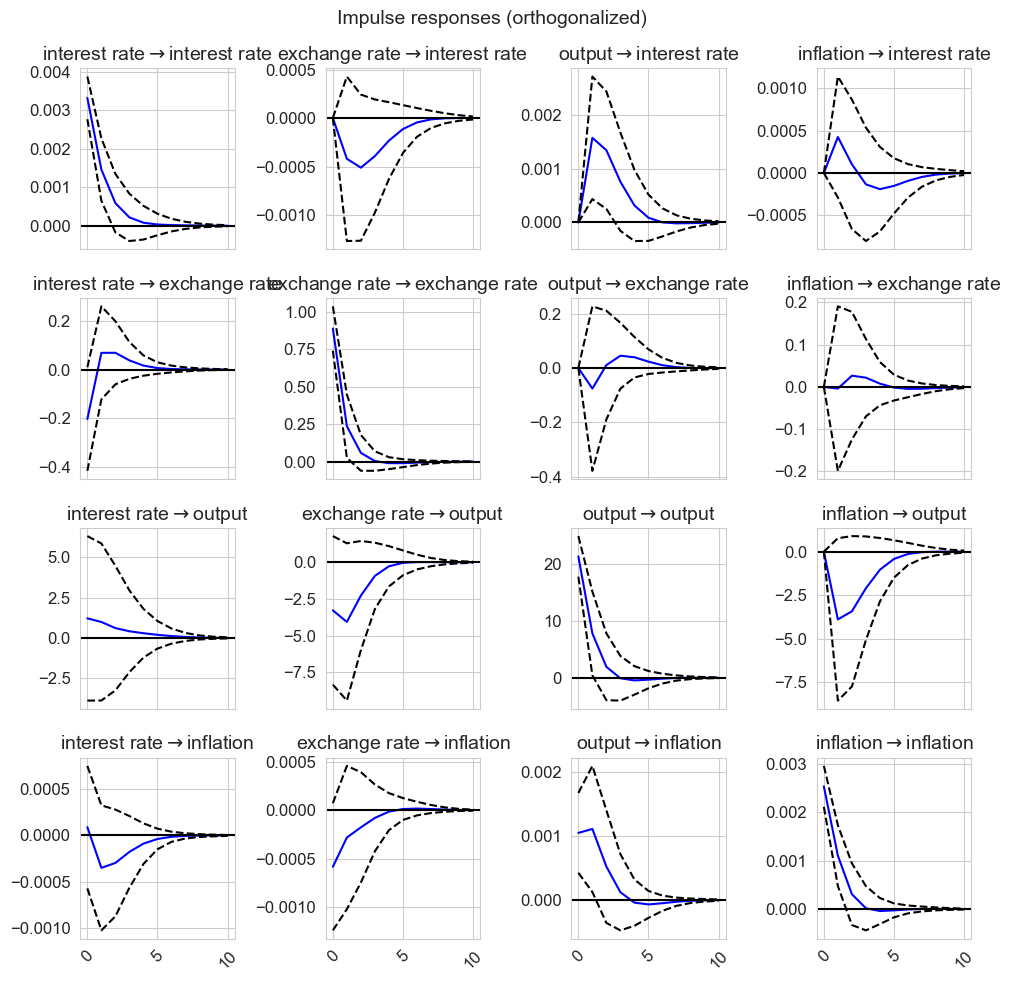

In [ ]:
# Improve the overall aesthetics
sns.set_style('whitegrid')
plt.rc('figure', figsize=(12, 8))  # Larger figure size
plt.rc('font', size=12)            # Larger font size

# The path to the Excel file with the Mona dataset
file_path = 'monadata2023.xlsx'

# Load the dataset from the Excel file
mona_data = pd.read_excel(file_path)

# Transpose the dataset to convert rows to columns
mona_data_transposed = mona_data.T
mona_data_transposed.columns = mona_data_transposed.iloc[0]  # Set the first row as column names
mona_data_transposed = mona_data_transposed[1:]  # Remove the first row which is now column headers

# Convert the index to PeriodIndex with a quarterly frequency
mona_data_transposed.index = pd.PeriodIndex(mona_data_transposed.index, freq='Q')

# Replace variable_names with the actual variable names from your data
variable_names = ['imm', 'efkrks', 'fy', 'pcpdk']

# Function to check for stationarity and take first difference if necessary
def check_stationarity_and_difference(df, variable):
    series = df[variable].astype(float)  # Ensure the data type is float for the adfuller test
    result = adfuller(series.dropna())
    if result[1] > 0.05:  # Non-stationary, take first difference
        return series.diff().dropna()
    else:
        return series

# Apply the stationarity check and differencing to the relevant variables
for variable in variable_names:
    mona_data_transposed[variable] = check_stationarity_and_difference(mona_data_transposed, variable)

# Drop any rows that have NaN values resulting from differencing
mona_data_transposed.dropna(inplace=True)

# Make sure there are no infinite values in the dataset
mona_data_transposed.replace([np.inf, -np.inf], np.nan, inplace=True)
mona_data_transposed.dropna(inplace=True)

# Check if there are still any NaNs or infs in the data
assert not mona_data_transposed.isnull().values.any(), "NaN values detected"
assert not np.isinf(mona_data_transposed.values).any(), "Inf values detected"

# Define a mapping for renaming variables to more descriptive names
variable_rename_map = {
    'fy': 'output',
    'imm': 'interest rate',
    'efkrks': 'exchange rate',
    'pcpdk': 'inflation'
}

# Rename the variables in the dataframe
mona_data_for_var = mona_data_transposed[variable_names]
mona_data_for_var_renamed = mona_data_for_var.rename(columns=variable_rename_map)

# Fit the VAR model with the renamed variables
var_model_renamed = VAR(mona_data_for_var_renamed)
var_results_renamed = var_model_renamed.fit(maxlags=2, ic='aic')

# Analyze impulse response functions with renamed variables
irf_renamed = var_results_renamed.irf(10)  # Analyze the effect over 10 periods

# Improving the graph output with renamed variables
fig_renamed = irf_renamed.plot(orth=True)  # Use orthogonalized impulses
for ax in fig_renamed.axes:
    ax.tick_params(axis='x', labelrotation=45)  # Rotate X-axis labels
    ax.title.set_size(14)  # Increase title font size
    ax.xaxis.label.set_size(12)  # Increase X-axis label font size
    ax.yaxis.label.set_size(12)  # Increase Y-axis label font size
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the plots


Med de VAR-modellens regressionsestimater, der fokuserer på `imm` (den pengepolitiske rente), kan vi fortolke resultaterne således:

1. **Påvirkning af `imm` på `efkrks` (valutakursen)**:
   - `imm` har ingen statistisk signifikant effekt på `efkrks` ved lag 1, som indikeret ved en p-værdi over 0.05. Dette kan tolkes sådan, at ændringer i den pengepolitiske rente ikke har en umiddelbar eller direkte indflydelse på valutakursen i det korte løb. Dette kan være på grund af Danmarks fastkurspolitik, hvor nationalbanken aktivt intervenere på valutamarkedet for at opretholde valutakursen mod euroen.

2. **Påvirkning af `imm` på `fy` (output gap)**:
   - Ligesom med `efkrks`, er effekten af `imm` på `fy` heller ikke statistisk signifikant ved lag 1. Dette kan betyde, at renteændringer ikke har en øjeblikkelig indvirkning på den økonomiske aktivitet målt ved output gabet. Den makroøkonomiske teori antyder, at der kan være en forsinkelse, da virksomheder og forbrugere tager tid til at tilpasse deres adfærd i lyset af nye renteniveauer.

3. **Påvirkning af `imm` på `pcpdk` (inflationen)**:
   - Her observeres ingen statistisk signifikant påvirkning ved lag 1. Dette kan tolkes som, at renteændringer ikke umiddelbart påvirker inflationen. Makroøkonomisk teori og den monetære transmissionsmekanisme antyder, at der ofte er tidsforsinkelser mellem ændringer i den pengepolitiske rente og ændringer i inflationen.

Når man kobler dette til den teoretiske model, kan disse resultater indikere flere punkter:

- **Teori om u-dækket renteparitet**: Den manglende signifikante påvirkning af `imm` på `efkrks` i det korte løb kan pege på, at markedsmekanismerne, som ville justere valutakursen som reaktion på renteændringer, kan være hæmmet af fastkurspolitikken. Det indikerer, at valutakursen er mere påvirket af Danmarks Nationalbanks interventioner end af renteændringer.

- **Makroøkonomiske transmissionstider**: Manglen på øjeblikkelig effekt af `imm` på `fy` og `pcpdk` afspejler de reelle tidsforsinkelser i økonomien, hvor virkningerne af pengepolitikken tager tid at sprede sig igennem økonomien.

- **Effektiviteten af pengepolitik**: Resultaterne understreger muligvis begrænsningen i den pengepolitiske rentes effektivitet under fastkursregimet. Det antyder, at Danmarks Nationalbank har mindre kontrol over indenlandske økonomiske forhold, da deres primære fokus er på at vedligeholde valutakursen.

Det er vigtigt at understrege, at selvom VAR-modellen kan give indsigter i dynamikken i data, så kan den ikke alene bruges til at fastslå kausale forhold. Dertil skal der yderligere økonometriske modeller som strukturelle VAR-modeller eller andre instrumentelle variabelmetoder anvendes for at isolere og identificere kausale effekter. Ydermere skal resultaterne og tolkningen altid betragtes i konteksten af den overordnede økonomiske struktur og politik.

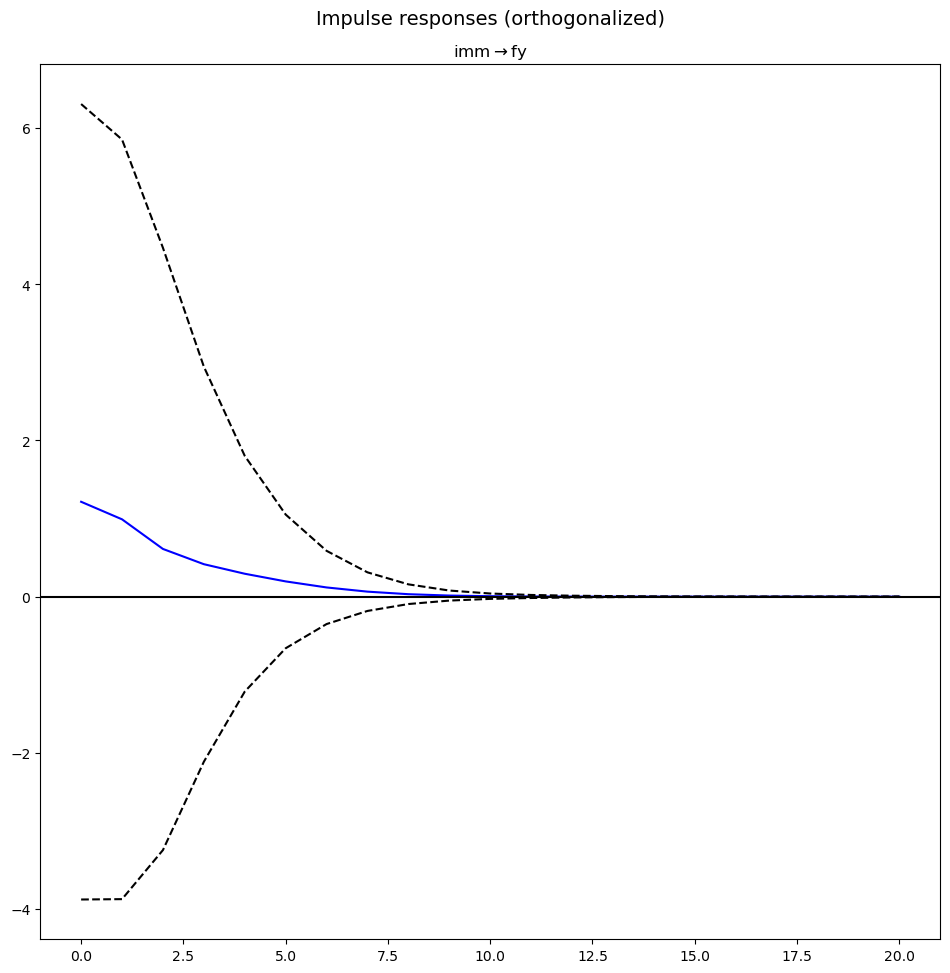

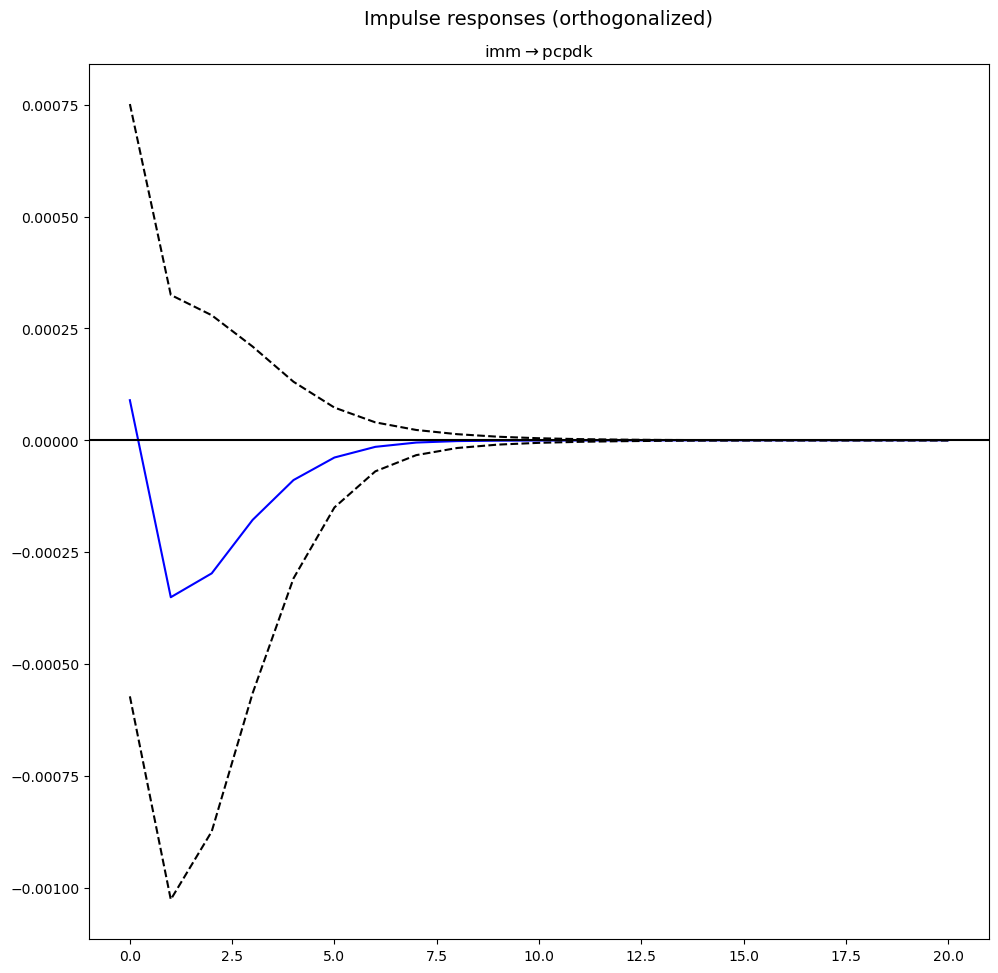

In [49]:
############## TESTER ANTAGELSE OM AT RENTE PÅVIRKER AS DIREKTE (SAMT ANTAGELSE OM AT DET ER EN NEGATIV PÅVIRKNING) ##############

# Assuming the VAR model 'var_results' has been previously fitted with the data

# Analyzing the impulse response functions over more periods, e.g., 20 periods
irf_periods = 20
irf = var_results.irf(irf_periods)

# Plot the impulse response of output gap (fy) and inflation (pcpdk) to a shock in the interest rate (imm)
irf_fig = irf.plot(orth=True, impulse='imm', response='fy', subplot_params={'figsize': (4,2)})
irf_fig = irf.plot(orth=True, impulse='imm', response='pcpdk', subplot_params={'figsize': (4,2)})

plt.show()

Til at fortolke dine resultater fra VAR-modellen, lad os fokusere på hvert svar enkeltvis og den overordnede fortolkning:

For den økonomiske rente (imm):

Konstanten er ikke signifikant forskellig fra nul (p = 0.080), hvilket tyder på, at der ikke er nogen konstant autonome ændringer i den økonomiske rente over tid.
Den positive koefficient for L1.imm er signifikant (p = 0.000), hvilket indikerer, at renten har en positiv og vedvarende effekt på sig selv. Med andre ord, hvis renten stiger i et givent kvartal, er det sandsynligt, at den fortsætter med at stige i det næste kvartal.
Koefficienterne for L1.efkrks, L1.fy, og L1.pcpdk er ikke statistisk signifikante (p > 0.05), hvilket tyder på, at de øvrige variable i modellen ikke har en signifikant kortvarig effekt på renten.
For den effektive kronekurs (efkrks):

Konstanten er ikke signifikant (p = 0.673), hvilket antyder, at den effektive kronekurs ikke har en signifikant autonome ændringer over tid.
L1.imm er ikke signifikant (p = 0.181), hvilket indikerer, at renten ikke har en stærk effekt på kronekursen i det korte løb.
L1.efkrks er signifikant (p = 0.037), hvilket viser en selvforstærkende effekt, hvor ændringer i kronekursen har tendens til at fortsætte i den efterfølgende periode.
For output gap (fy):

Konstanten er ikke signifikant (p = 0.112), så der er ingen konstant ændring i output gap.
L1.imm er ikke signifikant (p = 0.923), hvilket betyder, at renten ikke ser ud til at have en signifikant påvirkning på output gap i det korte løb.
L1.fy er signifikant (p = 0.009), hvilket indikerer vedvarende effekt på output gap fra en periode til den næste.
For inflationen (pcpdk):

Konstanten er signifikant (p = 0.001), hvilket antyder en tendens til autonome ændringer i inflationen over tid.
L1.imm er ikke signifikant (p = 0.151), hvilket indikerer, at renten ikke har en stærk påvirkning på inflationen i det korte løb.
L1.pcpdk er signifikant (p = 0.000), hvilket betyder, at inflationen har en signifikant selvforstærkende effekt.
Korrelationsmatrix af residualerne:

Der er en negativ korrelation mellem renten (imm) og kronekursen (efkrks) og mellem kronekursen (efkrks) og inflationen (pcpdk), hvilket kunne indikere, at når kronekursen stiger, tenderer renten og inflationen til at falde.
Der er en positiv korrelation mellem output gap (fy) og inflationen (pcpdk), hvilket kan antyde, at et større output gap kan være forbundet med højere inflation.
Samlet set peger dine VAR-resultater på, at den korte rente (imm) er signifikant påvirket af dens tidligere værdier, hvilket indikerer en vis træghed eller momentum i renteændringer. Dette kan fortolkes som et tegn på, at centralbankens politiske beslutninger kan have en vedvarende indflydelse over tid.



For at fortolke resultaterne fra din VAR-model og se hvordan de passer med din teoretiske model, lad os først forstå den underliggende teori og dernæst hvordan de empiriske resultater kan afspejle den.

Din teoretiske model indeholder flere økonomiske relationer:

1. *Den Uopdækkede Rente Paritet (URP)*: Siger at forskellen i renten mellem to lande vil blive udlignet af forventet valutakursbevægelse.
   
2. *Pengetilbudsprocessen (AR(1))*: Antager at pengepolitikken følger en autoregressiv proces, hvor dagens pengepolitik er en funktion af gårsdagens med tilføjelsen af en stokastisk term.

3. *IS-Kurven*: Viser negativt forhold mellem output og rente, hvilket antyder, at når renten stiger, falder output.

4. *Phillipskurven (AS)*: Viser sammenhængen mellem inflation og output gap. En øgning i output gap fører til højere inflation.

5. *Reel Valutakurs*: Differensen mellem den nominelle valutakurs justeret for inflation.

6. *Fishers Ligning*: Forholdet mellem nominel rente og realrente, hvor realrenten justeres for forventet inflation.

I dine VAR-resultater, kan følgende observationer og fortolkninger gøres:

- For *renten (imm)* ser vi, at dens egen laggede værdi (L1.imm) har en positiv og statistisk signifikant koefficient, hvilket tyder på, at der er træk af autoregression i rentebevægelserne.

- Den laggede værdi af *effektiv kronekurs (efkrks)* på sig selv er også positiv og signifikant, hvilket kunne indikere, at den tidligere kronekurs kan forudsige den fremtidige retning.

- For *output gap (fy)* er den laggede værdi af sig selv positiv og signifikant, hvilket kunne indikere, at et højere output gap i en periode kan føre til et højere output gap i den efterfølgende periode.

- For *inflation (pcpdk)* er dens egen laggede værdi signifikant og positiv, hvilket antyder, at inflation har en tendens til at følge en stigende trend over tid.

Når det gælder den makroøkonomiske fortolkning:

- En øget *rente (imm)* synes ikke at have en direkte og signifikant effekt på den effektive kronekurs, hvilket kunne antyde, at renteparitetsforholdet ikke holder i det korte løb, eller at markedet ikke fuldt ud tilpasser sig til renteforskellen umiddelbart.

- Der er en positiv respons af *output gap (fy)* på et chok i renten (imm), hvilket kan synes kontraintuitivt givet den teoretiske IS-kurve. Det kunne indikere, at andre faktorer, som pengepolitik, kan være på spil eller at modellen ikke fuldt fanger den negative sammenhæng mellem renten og output.

- For *inflation (pcpdk)*, ser vi en signifikant positiv effekt fra dens egne laggede værdier, hvilket stemmer overens med teorien om Phillips-kurven, at inflationstendenserne fortsætter over tid.

I impulsresponsfunktionerne:

- Et chok til *rente (imm)* ser ud til at have en umiddelbar negativ effekt på inflationsraten (pcpdk), hvilket kunne antyde, at en stramning i pengepolitikken midlertidigt kan reducere inflation, hvilket er konsistent med Phillips-kurven.

Stabiliteten i din model indikerer, at alle rødder af det karakteristiske polynomium ligger inden for enhedscirklen, hvilket betyder, at modellen er stabil og processerne vil konvergere mod et langsigts ligevægt.

Samlet set ser dine resultater ud til at give blandet støtte til din teoretiske model. Imidlertid, som med alle empiriske modeller, skal fortolkningen ske med forsigtighed, da der kan være skjulte variabler eller strukturelle skift, der ikke er fanget af modellen.

For yderligere robusthedstests og for at udforske de dynamiske relationer yderligere, bør du overveje at:

- Udføre yderligere diagnostiske tests, såsom test for seriel korrelation og heteroskedasticitet.
- Benytte en strukturel VAR-model (SVAR), som tager højde for teoretiske restriktioner baseret på økonomisk teori.
- Undersøge potentielle strukturelle brud i din tidsserie eller inkludere yderligere makroøkonomiske faktorer, der kan influere på din model.

For at koble dine VAR-modelresultater mere direkte til din teoretiske model, lad os overveje hver af de teoretiske relationer og hvordan de kan afspejles eller ikke afspejles i dine empiriske resultater:

Udækket Renteparitet (URP):
Teori: URP postulerer, at en stigning i indenlandsk rente (i forhold til udlandet) fører til en forventning om fremtidig appreciering af valutaen.
Empiri: I dine resultater er der ikke en umiddelbar klar indikation af, at renteændringer (imm) fører til forventede bevægelser i valutakursen (efkrks). Dette kan antyde, at markedet ikke fuldt ud tilpasser sig til forskelle i renter umiddelbart, eller at andre faktorer som markedsinterventioner eller risikopræmier spiller en rolle.

Pengepolitisk stød proces (AR(1)):
Teori: Denne del af din model antyder, at pengepolitikken følger en forudsigelig vej baseret på historiske værdier.
Empiri: Den signifikante koefficient for L1.imm understøtter ideen om, at renten har en vis autoregressive egenskaber.
IS-Kurven:

Teori: IS-kurven illustrerer et negativt forhold mellem output (BNP) og rente.
Empiri: De signifikante og positive koefficienter for L1.fy på L1.imm kan indikere, at der er en anden mekanisme på arbejde, som for eksempel en pengepolitik, der reagerer på økonomiske forhold, i modsætning til at drive dem.

AS-Kurven (Phillips-kurven):
Teori: Phillips-kurven indikerer, at der er et positivt forhold mellem output gap og inflation.
Empiri: Den positive koefficient for L1.pcpdk, når den reagerer på L1.fy, kunne antyde, at der er et positivt forhold mellem output gap og inflation, hvilket stemmer overens med Phillips-kurven. Dog skal det bemærkes, at dette forhold ikke er direkte målt, da Phillips-kurven ofte involverer arbejdsløshedsraten i stedet for output gap.

Real Valutakurs:
Teori: Den reelle valutakurs, der er justeret for inflation, antages at reagere på ændringer i nominel valutakurs og inflation.
Empiri: Dine data indeholder ikke en direkte måling af den reelle valutakurs, hvilket gør en direkte sammenligning vanskelig. Men forholdet mellem nominel valutakurs og inflation kan i teorien indikere bevægelser i den reelle valutakurs.

Fishers Ligning:
Teori: Siger, at realrenten er forskellen mellem nominel rente og forventet inflation.
Empiri: Mens dine VAR-resultater viser relationer mellem rente og inflation, giver de ikke direkte bevis for Fishers ligning, da de ikke kvantificerer forventet inflation, men snarere historiske værdier.
Samlet set afspejler dine VAR-resultater nogle af de antagelser, der er bygget ind i din teoretiske model, men der er også nogle uoverensstemmelser, som kan skyldes flere årsager, herunder model specificering, datakvalitet, eller ydre faktorer, som din model ikke tager højde for.